In [1]:
from flaky_lib import *
import re
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

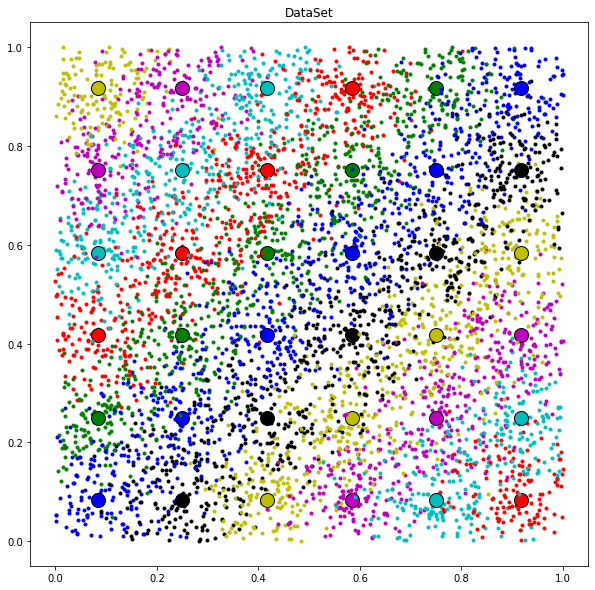

In [2]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing


samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

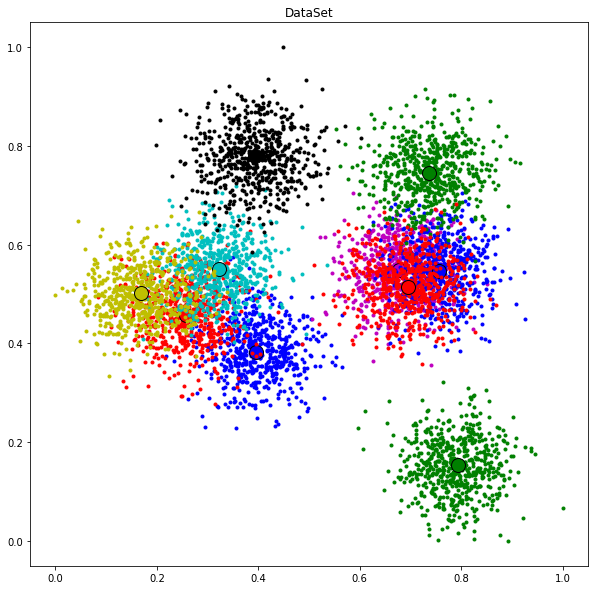

In [3]:
Drawing = True # If n_features > 2 then Drawing = True

grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = generate_dataset1(n_features, n_samples, n_cluster, standard_deviation)


if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

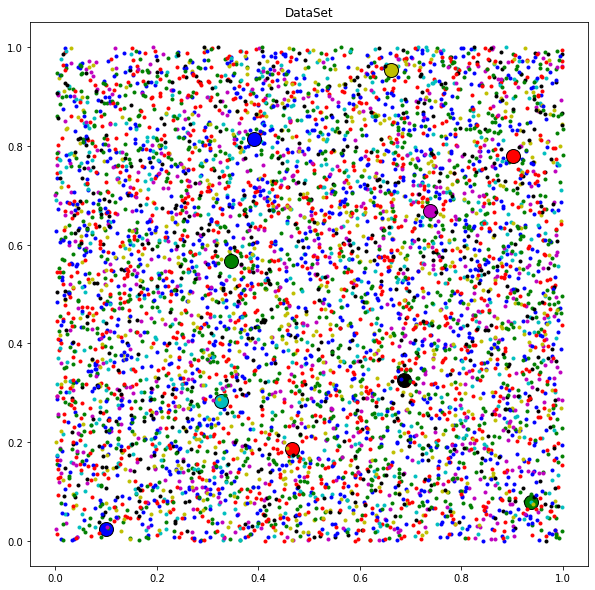

In [4]:
Drawing = True # If n_features > 2 then Drawing = True

n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if Drawing:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [7]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 24.609596104761774

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 2.71 ms


# Initialization by Random Centroids

In [8]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 51.750227712574414

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.7 ms


# Initialization by K-Means++

In [11]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 30.18352808683005

CPU times: user 32 ms, sys: 16 ms, total: 48 ms
Wall time: 20.9 ms


# K-Means initialized by True Centroids

In [13]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.71772430524213
Iterations: 28
Clusters: 36

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 20.8 ms


# K-Means initialized by K-Means++ with sample_objectives as weights

In [15]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.652726961415986
Iterations: 76
Clusters: 36



# K-Means initialized by Random Centroids

In [17]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.488660385200554
Iterations: 81
Clusters: 36

CPU times: user 240 ms, sys: 8 ms, total: 248 ms
Wall time: 63.8 ms


# K-Means initialized by K-Means++

In [19]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.931528706033102
Iterations: 74
Clusters: 36

CPU times: user 272 ms, sys: 16 ms, total: 288 ms
Wall time: 83.3 ms


# K-Means initialized by K-Means++ (sklearn)

In [21]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1, n_jobs=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 24.238773562922535
Iterations: 28
CPU times: user 1.47 s, sys: 72 ms, total: 1.54 s
Wall time: 261 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [23]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.703786964713515
Iterations: 12
Clusters: 36

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 80.7 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [25]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.276836147524847
Iterations: 40
Clusters: 36

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 328 ms


# H-Means initialized by Random Membership Distribution

In [27]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.482478914833887
Iterations: 34
Clusters: 36

CPU times: user 244 ms, sys: 4 ms, total: 248 ms
Wall time: 252 ms


# K-H-Means initialized by True Centroids

In [28]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.701838760714182
Iterations: 36
Clusters: 36

CPU times: user 5.57 s, sys: 24 ms, total: 5.59 s
Wall time: 5.53 s


# K-H-Means initialized by K-Means++

In [29]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.269656127000662
Iterations: 97
Clusters: 36

CPU times: user 360 ms, sys: 32 ms, total: 392 ms
Wall time: 217 ms


# Simple Membership Shaking VNS

In [31]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 3000
k_max_iters = 3000
h_tol = 0.00000001
k_tol = 0.00000001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.785906491902537
Iterations: 73
Clusters: 36

23.785906491902498 1
23.783326727802333 1
23.78332672780233 1
23.781102708792346 3
23.78110270879234 1
23.781102708792336 3
23.78108101715161 2
23.781081017151607 2
23.78045022322945 3
23.780318151933702 1
23.75028282805752 2
23.750282828057507 1
23.75024477545592 1
23.750244775455915 1
23.75024477545591 2
23.75024477545591

Final objective: 23.75024477545591
Total number of iterations: 675
Clusters: 36

CPU times: user 14.4 s, sys: 972 ms, total: 15.4 s
Wall time: 10.1 s


# Solution Visualization

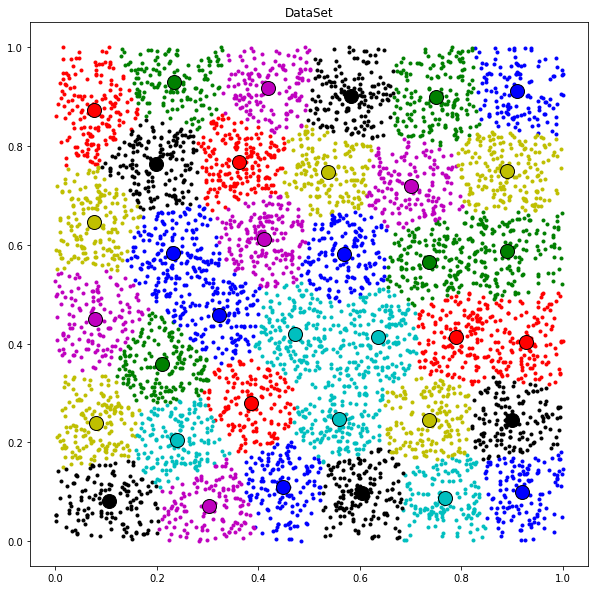

In [33]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [35]:
%%time

k_max_iters = 600
k_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.324948091124305
Iterations: 51
Clusters: 36

24.19248305252419
24.13926232507483
24.115429155503296
24.04608464180457
23.994740503832123
23.993037593670415
23.951560285247027
23.950622798792338
23.950090982288838
23.950090982288838

Objective: 23.950090982288838
Global Iterations: 262
Local Iterations: 41
Clusters: 36

CPU times: user 46 s, sys: 4.79 s, total: 50.8 s
Wall time: 10.1 s


# Solution Visualization

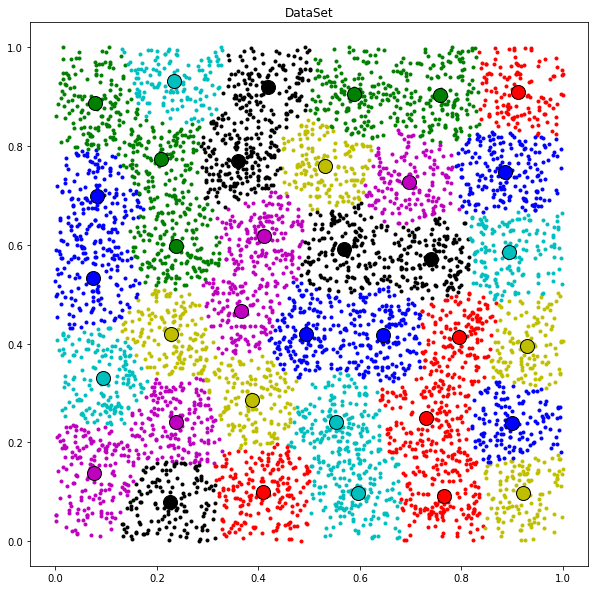

In [36]:
draw_dataset(samples, centroids, sample_membership)

# Simple Center Shaking VNS

In [38]:
%%time

kmax = 5

local_max_iters = 600
local_tol=0.000001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.414291414983627
Iterations: 35
Clusters: 36

24.227629825981296 2
24.045795706787732 1
23.85867322984924 3
23.857571194536604 2
23.856919140857055 2
23.84286843111193 1
23.784416370321416 2
23.784322599397676 5
23.77952323122299 2
23.73760549200599 5
23.732666194220563 4
23.727121436969593 5
23.71836123244495 4
23.7076565941669 3
23.706916906223316 1
23.706063105663045 1
23.702751365826956 1
23.69849896296719 2
23.698293761825376 1
23.69631377289861 1
23.694532804383464 2
23.694483999997857 1
23.694297346365815 2
23.693839169035353 2
23.692304095702518 1
23.69227033425381 1
23.69227033425381

Objective: 23.69227033425381
Global Iterations: 615
Local Iterations: 3
Clusters: 36

CPU times: user 46.7 s, sys: 5.43 s, total: 52.1 s
Wall time: 10 s


# Solution Visualization

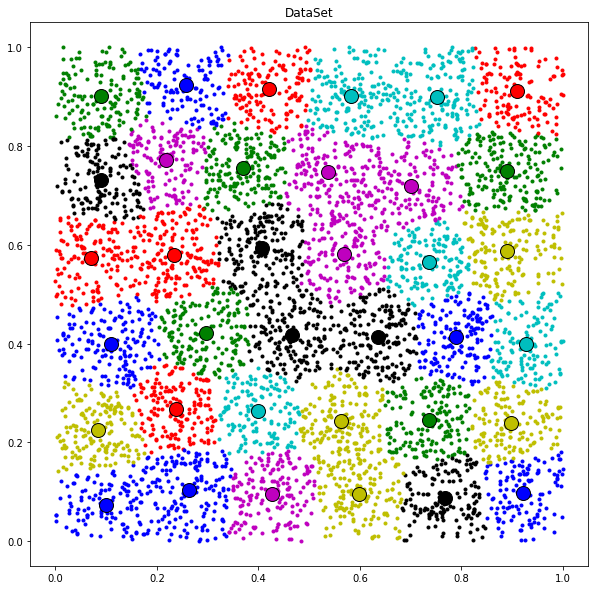

In [39]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [43]:
%%time

printing=True
local_max_iters=300
local_tol=0.00001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
24.777872973669638

Center Shaking VNS:
23.954789431466132 1
23.87157180444327 3
23.87084529836743 1
23.820858170691814 2
23.701078655971497 1
23.700674242134028 1
23.696702263642425 2
23.69512593592601 1
23.694218080285776 1
23.6908522672026 3
23.680450501976207 3
23.680003050790166 1
23.678407963315443 1
23.678407963315443

Membership Shaking VNS:
23.67695736814131 1
23.67688581296052 1
23.676885812960517 1
23.676229899882877 5
23.676145527219735 1
23.67614552721973 1
23.675989752646693 2
23.675989752646686 4
23.67553919972297 4
23.675539199722966 1
23.675312453161354 4
23.67531245316135 4
23.675312453161347 2
23.675312453161347

Center Shaking VNS:
23.675312453161347

Membership Shaking VNS:
23.675312453161347

K-H-means:
23.675312453161357

CPU times: user 37.7 s, sys: 3.85 s, total: 41.6 s
Wall time: 12.1 s


# Solution Visualization

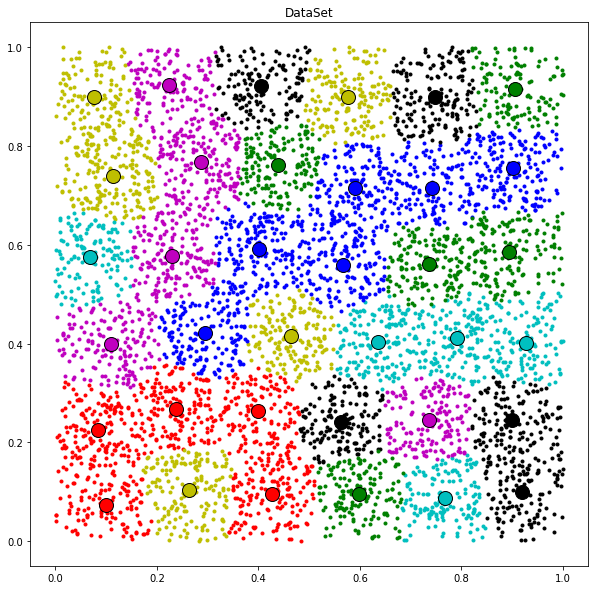

In [44]:
draw_dataset(samples, centroids, sample_membership)